In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [ ]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [ ]:
def entropy(labels):
  classes = {}
  for label in labels:
      if label not in classes:
          classes[label] = 0
      classes[label] += 1

  chaos = 0
  for label in classes:
    p =  classes[label] / len(labels)
    if p != 0:
      chaos -= p * np.log2(p)
  return chaos

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, current_criterion, criterion='gini'):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    if criterion == 'entropy':
        return current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    
    return current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf, criterion='gini'):

    if criterion == 'entropy':
      current_criterion = entropy(labels)
    
    current_criterion = gini(labels)
      
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            if criterion == 'entropy':
              current_quality = quality(true_labels, false_labels, current_criterion, criterion='entropy')
              
            current_quality = quality(true_labels, false_labels, current_criterion, criterion='gini')
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf=5, max_depth=None, depth=0, max_leaves=1000, criterion='gini'):
    if criterion == 'entropy':
      quality, t, index = find_best_split(data, labels, min_leaf, criterion='entropy')
    
    quality, t, index = find_best_split(data, labels, min_leaf, criterion='gini')

    global counter_node
    global counter_leaf

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        counter_leaf += 1
        return Leaf(data, labels)

    if (max_depth is not None) and (depth >= max_depth):
        counter_leaf += 1
        return Leaf(data, labels)

    if max_leaves is not None:
        if counter_leaf <= max_leaves or counter_node <= (max_leaves/2):
              true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
              counter_node += 1
              depth += 1

    # Рекурсивно строим два поддерева
              true_branch = build_tree(true_data, true_labels, 
                                     min_leaf, max_depth, depth, (max_leaves-counter_leaf))
              false_branch = build_tree(false_data, false_labels, 
                                      min_leaf, max_depth, depth, (max_leaves-counter_leaf))
        elif (counter_leaf > max_leaves) or ((counter_node + 1) > (max_leaves / 2)):
              counter_leaf += 1
              return Leaf(data, labels)
        
    else:
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        counter_node += 1
        depth += 1 

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, 
                                 min_leaf, max_depth, depth, max_leaves)
        false_branch = build_tree(false_data, false_labels, 
                                  min_leaf, max_depth, depth, max_leaves)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
classification_data, classification_labels = datasets.make_classification( n_samples = 1200,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, 
                                                      random_state = 5
                                                                         )

In [ ]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
counter_leaf = 0 
counter_node = 0
my_tree_gini = build_tree(train_data, train_labels, min_leaf=6, max_depth=10)

In [ ]:
counter_leaf = 0 
counter_node = 0
my_tree_entropy = build_tree(train_data, train_labels, min_leaf=6, max_depth=10, criterion='entropy')

In [ ]:
# Получим ответы для обучающей выборки 
train_answers_gini = predict(train_data, my_tree_gini)
train_answers_entropy = predict(train_data, my_tree_entropy)

In [ ]:
# И получим ответы для тестовой выборки
answers_gini = predict(test_data, my_tree_gini)
answers_entropy = predict(test_data, my_tree_entropy)

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
train_accuracy_entropy = accuracy_metric(train_labels, train_answers_entropy)
test_accuracy_gini = accuracy_metric(test_labels, answers_gini)
test_accuracy_entropy = accuracy_metric(test_labels, answers_entropy)

In [ ]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

Text(0.5, 1.0, 'Test accuracy GINI =93.61')

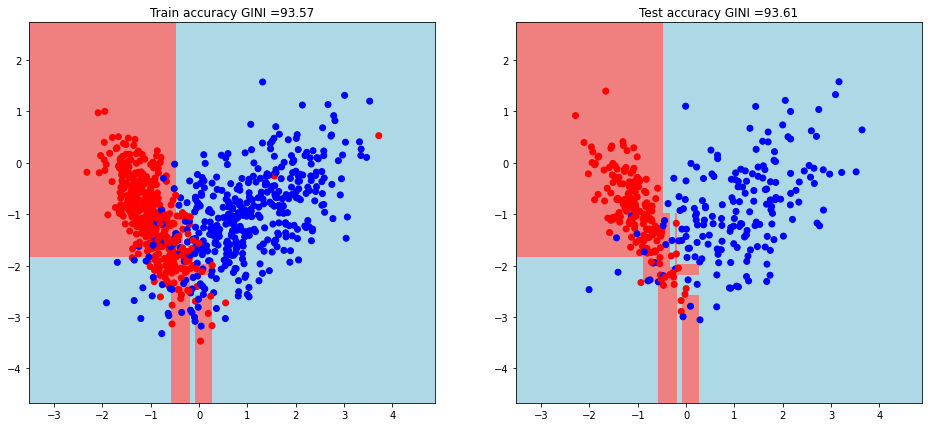

In [ ]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_gini)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy GINI ={train_accuracy_gini:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy GINI ={test_accuracy_gini:.2f}')

Text(0.5, 1.0, 'Test accuracy ENTROPY =93.61')

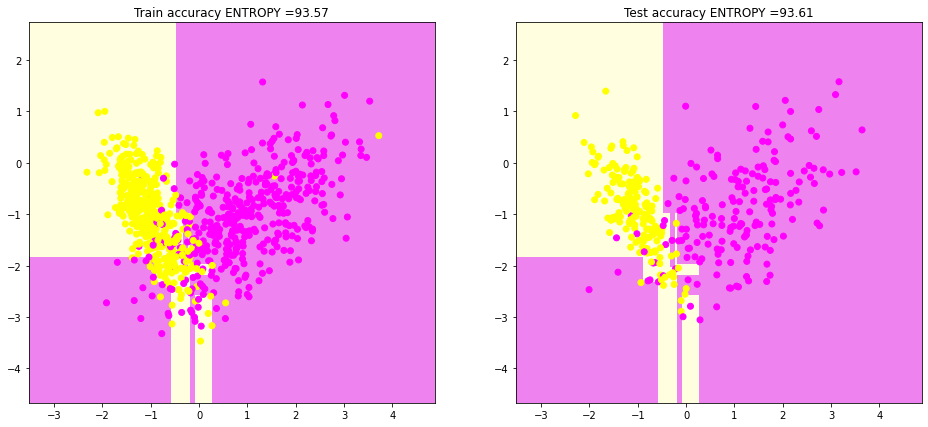

In [ ]:
colors = ListedColormap(['yellow', 'magenta'])
light_colors = ListedColormap(['lightyellow', 'violet'])

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_entropy)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy ENTROPY ={train_accuracy_entropy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy ENTROPY ={test_accuracy_entropy:.2f}')

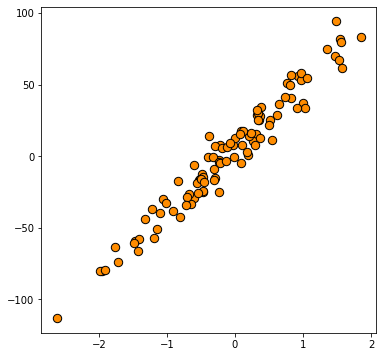

In [ ]:
from sklearn import datasets

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, bias=5, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

In [ ]:
class Reg_Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.lables)
        return prediction        

In [ ]:
def reg_quality(left_labels, right_labels, current_criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_criterion - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [ ]:
def reg_find_best_split(data, labels, min_leaf):

    current_criterion = np.var(data)
      
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
        
            current_quality = reg_quality(true_data, false_data, current_criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
def reg_build_tree(data, labels, min_leaf=5, max_depth=None, depth=0, max_leaves=1000):
    
    quality, t, index = reg_find_best_split(data, labels, min_leaf)

    global counter_node
    global counter_leaf

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        counter_leaf += 1
        return Reg_Leaf(data, labels)

    if (max_depth is not None) and (depth >= max_depth):
        counter_leaf += 1
        return Reg_Leaf(data, labels)

    if max_leaves is not None:
        if counter_leaf <= max_leaves or counter_node <= (max_leaves/2):
              true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
              counter_node += 1
              depth += 1

    # Рекурсивно строим два поддерева
              true_branch = build_tree(true_data, true_labels, 
                                     min_leaf, max_depth, depth, (max_leaves-counter_leaf))
              false_branch = build_tree(false_data, false_labels, 
                                      min_leaf, max_depth, depth, (max_leaves-counter_leaf))
        elif (counter_leaf > max_leaves) or ((counter_node + 1) > (max_leaves / 2)):
              counter_leaf += 1
              return Reg_Leaf(data, labels)
        
    else:
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        counter_node += 1
        depth += 1 

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, 
                                 min_leaf, max_depth, depth, max_leaves)
        false_branch = build_tree(false_data, false_labels, 
                                  min_leaf, max_depth, depth, max_leaves)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def mse (y, y_pred):
  return np.mean ((y - y_pred)**2)

In [ ]:
from sklearn import model_selection

train_data_reg, test_data_reg, train_labels_reg, test_labels_reg = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
my_reg_tree = reg_build_tree(train_data_reg, train_labels_reg)

In [ ]:
reg_pred_train = predict(train_data_reg, my_reg_tree)
reg_pred_test = predict(test_data_reg, my_reg_tree)

In [ ]:
reg_mse_train = mse(train_labels_reg, reg_pred_train)
reg_mse_test = mse(test_labels_reg, reg_pred_test)

In [ ]:
reg_mse_test

284.77599432547987

In [ ]:
reg_mse_train

281.12084015205875